In [2]:
import os, sys, glob
import pandas as pd
import subprocess

def run_command(cmd, cwd=None):
    """Utility function to run a shell command."""
    return subprocess.check_output(cmd, shell=True, cwd=cwd).decode().strip()

def copy_contents(in_dir, out_dir):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    if not os.path.exists(in_dir):
        raise ValueError(f'Input directory {in_dir} does not exist.')
    
    run_command(f'cp -r {in_dir}/* {out_dir}')


In [14]:
# load session index with environment that has cmlreaders (can't install cmlreaders for py3.10)
exps = ['ltpFR2']
if sys.version.split(' ')[0] >= '3.10' and sys.version.split(' ')[0] < '3.11':
    index_df = pd.read_csv(f'session_index_{"-".join(exps)}.csv')
else:
    import cmlreaders as cml

    index_df = cml.get_data_index('ltp')
    print('Available experiments:\n', index_df.experiment.unique())
    index_df = index_df.query('experiment in @exps')
    index_df.to_csv(f'session_index_{"-".join(exps)}.csv')

    # load example session events
    sess_df = index_df.iloc[25]
    r = cml.CMLReader(subject=sess_df.subject, session=sess_df.session, experiment=sess_df.experiment)
    evs = r.load('events')
    print('Event types:\n', evs.type.unique())

In [28]:
def get_folders_containing_files(directory=".", pattern="*"):
    """
    Get folders containing files that match the specified glob pattern.
    
    Parameters:
    - directory (str): The starting directory for the search.
    - pattern (str): The glob pattern to search for. e.g. "*.wav", "audio_*.mp3", "document_?.txt", etc.

    Returns:
    - list: A list of folders containing files that match the glob pattern.
    """

    # Get all the files matching the pattern in the directory and its sub-directories.
    matching_files = glob.glob(os.path.join(directory, '**', pattern), recursive=True)
    
    # Get the unique directories containing the files that match the pattern.
    folders = set(os.path.dirname(file) for file in matching_files)

    return list(folders)


# build train-val-test split
from sklearn.model_selection import GroupShuffleSplit

random_seed = 42
train_prop = 0.5
val_prop = 0.2
test_prop = 0.3
assert train_prop + val_prop + test_prop == 1

index_df['split_group'] = index_df['subject'] + '_' + index_df['experiment']
train_val_idx, test_idx = next(GroupShuffleSplit(train_size=train_prop + val_prop, 
                                                 test_size=test_prop, 
                                                 random_state=random_seed).split(index_df,
                                                                                 groups=index_df['split_group']))
train_idx, val_idx = next(GroupShuffleSplit(train_size=train_prop / (train_prop + val_prop),
                                            test_size=val_prop / (train_prop + val_prop),
                                            random_state=random_seed + 1).split(index_df.iloc[train_val_idx],
                                                                                groups=index_df.iloc[train_val_idx]['split_group']))
index_dfs = {'train': index_df.iloc[train_val_idx].iloc[train_idx],
             'val': index_df.iloc[train_val_idx].iloc[val_idx],
             'test': index_df.iloc[test_idx]}

# assert no overlap across splits
assert not set(index_dfs['train'].split_group).intersection(index_dfs['test'].split_group)
assert not set(index_dfs['train'].split_group).intersection(index_dfs['val'].split_group)
assert not set(index_dfs['val'].split_group).intersection(index_dfs['test'].split_group)

# obtain session data directories
input_dirs = {'train': list(), 'val': list(), 'test': list()}
for exp in exps:
    # get all session directories containing .wav files
    wav_dirs = get_folders_containing_files(pattern="0.wav", directory=f'/data/eeg/scalp/ltp/{exp}')
    # drop sessions marked bad
    wav_dirs = {d for d in wav_dirs if not 'bad' in d.lower()}
    for split in input_dirs:
        # keep only sessions that were processed through event_creation for quality control
        exp_dirs = {f'/data/eeg/scalp/ltp/{sess.experiment}/{sess.subject}/session_{sess.session}' 
                    for _, sess in index_dfs[split].iterrows()}
        exp_dirs = exp_dirs.intersection(wav_dirs)
        input_dirs[split].extend(list(exp_dirs))

for split in input_dirs:
    print(f'{split} sessions available: {len(input_dirs[split])}')
print('Example session directories:')
input_dirs['train'][:5]

train sessions available: 1125
val sessions available: 536
test sessions available: 808
Example session directories:


['/data/eeg/scalp/ltp/ltpFR2/LTP123/session_13',
 '/data/eeg/scalp/ltp/ltpFR2/LTP312/session_0',
 '/data/eeg/scalp/ltp/ltpFR2/LTP373/session_23',
 '/data/eeg/scalp/ltp/ltpFR2/LTP207/session_14',
 '/data/eeg/scalp/ltp/ltpFR2/LTP327/session_14']

In [22]:
# obtain session processing output directories
base_dir = os.getcwd()

tags = ['base-whisperx']
all_output_dirs = dict()
all_input_dirs = dict()
output_dirs = dict()

for tag in tags:
    output_dirs[tag] = dict()
    all_input_dirs[tag] = list()
    all_output_dirs[tag] = list()
    for split in input_dirs:
        output_dirs[tag][split] = [os.getcwd() + f'/results/{tag}/{split}' + d if os.path.isabs(d) else os.path.join('results', tag, d)
                                   for d in input_dirs[split]]
        all_output_dirs[tag].extend(output_dirs[tag][split])
        all_input_dirs[tag].extend(input_dirs[split])
print('Sessions to process:', len(all_input_dirs[tag]))


# was thinking the easiest method to access ground truth would be to compare .csv automated annotation outputs with .ann files, 
# but then decided it'd be cleaner to just use cmlreaders

# # create data set with ground truth annotations (.ann) and word list files (.lst)

# dataset_path = f'data/{exp}'

# for split in splits:
#     split_path = os.path.join(dataset_path, split)
#     for path in output_dirs[tag][split]:
#         raw_data_path = path.split(f'{tag}/{split}')[-1]
#         cp_files = glob.glob(os.path.join(raw_data_path, '*.ann')) + glob.glob(os.path.join(raw_data_path, '*.lst'))
#         out_path = split_path + (raw_data_path if os.path.isabs(raw_data_path) else '/' + raw_data_path)
#         if not os.path.exists(out_path): os.makedirs(out_path)
#         for full_file in cp_files:
#             file = os.path.split(full_file)[-1]
#             run_command(f'cp {full_file} {os.path.join(out_path, file)}')

In [101]:
# save all annotation input/output directories
# import pickle
# with open('input_dirs.pkl', 'wb') as f:
#     pickle.dump(all_input_dirs, f)
# with open('output_dirs.pkl', 'wb') as f:
#     pickle.dump(all_output_dirs, f)
    
# # for convenience also save out output directories broken out by train/val/test splits
# with open('input_dirs_splits.pkl', 'wb') as f:
#     pickle.dump(input_dirs, f)
# with open('output_dirs_splits.pkl', 'wb') as f:
#     pickle.dump(output_dirs, f)

In [20]:
# load annotation input/output directories
import pickle
with open('input_dirs.pkl', 'rb') as f:
    input_dirs = pickle.load(f)
with open('output_dirs.pkl', 'rb') as f:
    output_dirs = pickle.load(f)

In [29]:
# # load original input/output directories that didn't contain subdirectories for splits ('{tag}/{split}') in paths
# import pickle
# with open('input_dirs_no_split.pkl', 'rb') as f:
#     old_all_input_dirs = pickle.load(f)
# with open('output_dirs_no_split.pkl', 'rb') as f:
#     old_all_output_dirs = pickle.load(f)


In [100]:
# # transfer output directories from original structure to structure including split subdirectories
# new_outs_no_split = set([d.replace('train/', '').replace('val/', '').replace('test/', '') for d in all_output_dirs[tag]])#[:10]#[0].split('data/')[-1]
# old_outs = set(old_all_output_dirs[tag])
# assert new_outs == old_outs

# for old_dir, new_dir in zip(old_all_output_dirs[tag], all_output_dirs[tag]):
#     try:
#         copy_contents(old_dir, new_dir)
#     except ValueError as e:
#         print(e)

Input directory /home1/rdehaan/projects/automated_annotation/results/base-whisperx/data/eeg/scalp/ltp/ltpFR2/LTP325/session_6 does not exist.
Input directory /home1/rdehaan/projects/automated_annotation/results/base-whisperx/data/eeg/scalp/ltp/ltpFR2/LTP385/session_14 does not exist.
Input directory /home1/rdehaan/projects/automated_annotation/results/base-whisperx/data/eeg/scalp/ltp/ltpFR2/LTP325/session_0 does not exist.
Input directory /home1/rdehaan/projects/automated_annotation/results/base-whisperx/data/eeg/scalp/ltp/ltpFR2/LTP310/session_11 does not exist.
Input directory /home1/rdehaan/projects/automated_annotation/results/base-whisperx/data/eeg/scalp/ltp/ltpFR2/LTP385/session_8 does not exist.
Input directory /home1/rdehaan/projects/automated_annotation/results/base-whisperx/data/eeg/scalp/ltp/ltpFR2/LTP327/session_17 does not exist.
Input directory /home1/rdehaan/projects/automated_annotation/results/base-whisperx/data/eeg/scalp/ltp/ltpFR2/LTP249/session_1 does not exist.
Inp

## Debugging session mismatch issue

In [47]:
tag = 'base-whisperx'
splits = ['train', 'val', 'test']
for inp, out in zip(input_dirs[tag], output_dirs[tag]):
    # print(inp)
    out_split = None
    for split in splits:
        if split in out: out_split = split
    if isinstance(out_split, type(None)): raise ValueError
    out_strip = out.split(f'{tag}/{out_split}')[-1]
    if inp != out_strip:
        print(inp)
        print(out_strip)
        print()

In [36]:
tag = 'base-whisperx'
for inp, out in zip(old_all_input_dirs[tag], old_all_output_dirs[tag]):
    # print(inp)
    out_strip = out.split(f'{tag}')[-1]
    assert inp == out_strip
    # print()

In [32]:
for i, d in enumerate(input_dirs[tag]):
    if 'LTP123' in d and 'session_5' in d:
        print(i)

387


In [33]:
old_all_input_dirs[tag][387]

'/data/eeg/scalp/ltp/ltpFR2/LTP307/session_9'

In [48]:
for i, d in enumerate(old_all_input_dirs[tag]):
    if 'LTP123' in d and 'session_5' in d:
        print(i)

133


In [50]:
input_dirs[tag][133]

'/data/eeg/scalp/ltp/ltpFR2/LTP385/session_3'

In [51]:
# load debug trial (LTP123 ltpFR2 session 5 trial 1)
exp = 'ltpFR2'
import cmlreaders as cml  # (can't install cmlreaders for py3.10)

index_df = cml.get_data_index('ltp')
print('Available experiments:\n', index_df.experiment.unique())
index_df = index_df.query('experiment == @exp')

# load example session events
sess_df = index_df.query('subject == "LTP123" and experiment==@exp and session==5').iloc[0]
r = cml.CMLReader(subject=sess_df.subject, session=sess_df.session, experiment=sess_df.experiment)
evs = r.load('events')
print('Event types:\n', evs.type.unique())


Available experiments:
 ['ltpFR' 'ltpFR2' 'VFFR' 'ltpRepFR' 'NiclsCourierClosedLoop'
 'NiclsCourierReadOnly' 'ltpDelayRepFRReadOnly' 'ltpDBOY1' 'prelim']
Event types:
 ['SESS_START' 'START' 'PROB' 'STOP' 'DISTRACTOR' 'WORD' 'REC_START'
 'REC_WORD' 'REC_WORD_VV' 'REST_REWET' 'SESS_END']


In [52]:
evs.columns

Index(['eegoffset', 'answer', 'begin_distractor', 'begin_math_correct',
       'eegfile', 'eogArtifact', 'experiment', 'final_distractor',
       'final_math_correct', 'intruded', 'intrusion', 'iscorrect', 'item_name',
       'item_num', 'list', 'montage', 'msoffset', 'mstime', 'phase',
       'protocol', 'recalled', 'rectime', 'serialpos', 'session', 'subject',
       'test', 'trial', 'type'],
      dtype='object')

In [53]:
rec_evs = evs.query('type == "REC_WORD" and trial == 1')[['subject', 'experiment', 'session', 'trial', 'item_name']]
rec_evs

,subject,experiment,session,trial,item_name
64,LTP123,ltpFR2,5,1,CRUTCH
65,LTP123,ltpFR2,5,1,WORKER
66,LTP123,ltpFR2,5,1,CHEMIST
67,LTP123,ltpFR2,5,1,DAUGHTER
68,LTP123,ltpFR2,5,1,SPOUSE
69,LTP123,ltpFR2,5,1,APPLE
70,LTP123,ltpFR2,5,1,PEACH
71,LTP123,ltpFR2,5,1,CARROT
72,LTP123,ltpFR2,5,1,TURNIP
73,LTP123,ltpFR2,5,1,LAPEL


# Run model

In [10]:
from automated_annot import run_whisperx
run_whisperx(all_input_dirs[tag][0], all_output_dirs[tag][0])

starting run_whisperx with
/data/eeg/scalp/ltp/ltpFR2/LTP299/session_5 /home1/rdehaan/projects/automated_annotation/results/base-whisperx/data/eeg/scalp/ltp/ltpFR2/LTP299/session_5


====== Device type : cpu ======
No language specified, language will be first be detected for each audio file (increases inference time).


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.1.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.0.0. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.0.1. Bad things might happen unless you revert torch to 1.x.
WAV files found:


Processing 16.wav...
loading audio /data/eeg/scalp/ltp/ltpFR2/LTP299/session_5/16.wav


FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

In [29]:
from automated_annot import run_whisperx
from cmldask import CMLDask
from dask.distributed import wait

tag = 'base-whisperx'
dask_args = {'job_name': 'auto_annotate', 'memory_per_job': "9GB", 'max_n_jobs': 35,
            'death_timeout': 600, 'extra': ['--no-dashboard'], 'log_directory': 'logs'}

client = CMLDask.new_dask_client_slurm(**dask_args)
dask_inputs = [all_input_dirs[tag][:1], all_output_dirs[tag][:1]]
futures = client.map(run_whisperx, *dask_inputs)
wait(futures)

Unique port for rdehaan is 51474
{'dashboard_address': ':51474'}
To view the dashboard, run: 
`ssh -fN rdehaan@rhino2.psych.upenn.edu -L 8000:192.168.86.140:44068` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser
starting run_whisperx with
/data/eeg/scalp/ltp/ltpFR2/LTP301/session_4 /home1/rdehaan/projects/automated_annotation/results/base-whisperx/data/eeg/scalp/ltp/ltpFR2/LTP301/session_4


====== Device type : cpu ======
WAV files found:


Processing 16.wav...
loading audio /data/eeg/scalp/ltp/ltpFR2/LTP301/session_4/16.wav


In [26]:
del client

In [55]:
# estimated number of days to run whisperx over data set assuming ~5 minutes per list recording
n_sess = 1200  #len(all_input_dirs[tag])
n_lists = 24
n_cores = 150
min_per_list = 5
n_days = n_sess * n_lists * min_per_list / (n_cores * 24 * 60)
print(f'Estimated days of model inference: {n_days:0.4}')

Estimated days of model inference: 0.6667


In [140]:
# get processed sessions and ZIP

tag = 'base-whisperx'
model_out = 'whisperx_out'

splits = ['train', 'val', 'test']
output_paths = dict()

if 'output_dir' not in globals():
    import pickle
    with open('output_dirs_splits.pkl', 'rb') as f:
        output_dirs = pickle.load(f)

dataset_path = os.path.join(f'results/{tag}')
for split in ['*'] + splits:
    split_path = os.path.join(dataset_path, f'{split}')
    path = os.path.join(split_path, f'data/eeg/scalp/ltp/ltpFR2/*/session_*/{model_out}/*.csv'.replace(' ', '').replace("'", ''))
    outputs = glob.glob(path)
    
    sess_path = os.path.join(split_path, f'data/eeg/scalp/ltp/ltpFR2/*/session_*/{model_out}'.replace(' ', '').replace("'", ''))
    sess_outputs = glob.glob(sess_path)
    print('Split:', split.replace('*', 'All'))
    print('\tNumber of processed .wav files:', len(outputs))
    if split == '*':
        print('\tNumber of processed sessions:', len(sess_outputs))
    else:
        print('\tNumber of processed sessions:', len(sess_outputs), '/', len(output_dirs[tag][split]))
    output_paths[split] = outputs

orig_cwd = os.getcwd()
os.chdir(dataset_path)
try:
    for split in splits:
        zip_file = f'{tag}_{split}.zip'
        if os.path.exists(zip_file): run_command(f'rm {zip_file}')
        run_command(f'zip -r {zip_file} {split}/')
except Exception as e:
    os.chdir(orig_cwd)
os.chdir(orig_cwd)


Split: All
	Number of processed .wav files: 55894
	Number of processed sessions: 2469
Split: train
	Number of processed .wav files: 25394
	Number of processed sessions: 1125 / 1125
Split: val
	Number of processed .wav files: 11912
	Number of processed sessions: 536 / 536
Split: test
	Number of processed .wav files: 18588
	Number of processed sessions: 808 / 808


In [2]:
# get word pool and sanity consistency across experiment
import pandas as pd
evs = pd.read_csv('/home1/rdehaan/projects/DataMemoryBrainsSolutions/data/LTPFR2_WORD__REC_WORD_EVENTS.csv')


In [3]:
evs.subject.unique().shape

(127,)

In [134]:
word_evs = evs.query('type == "WORD"')
word_evs.

Index(['Unnamed: 0', 'eegoffset', 'answer', 'begin_distractor',
       'begin_math_correct', 'eegfile', 'eogArtifact', 'experiment',
       'final_distractor', 'final_math_correct', 'intruded', 'intrusion',
       'iscorrect', 'item_name', 'item_num', 'list', 'montage', 'msoffset',
       'mstime', 'phase', 'protocol', 'recalled', 'rectime', 'serialpos',
       'session', 'subject', 'test', 'trial', 'type'],
      dtype='object')

In [12]:
evs.type.unique()

array(['WORD', 'REC_WORD'], dtype=object)

In [13]:
sub = "LTP123"
sess = 5
sess_evs = evs.query('subject == @sub and session == @sess and trial == 1 and type in ["REC_WORD"]')
sess_evs.mstime
# reltime from first word, so not from start of recall period since REC_START events not included in compiled event CSV
# correct with offset from automated annotations
sess_evs['reltime'] = sess_evs.mstime - sess_evs.mstime.iloc[0] + 734
sess_evs[['item_name', 'reltime']]

/tmp/ipykernel_30568/16988970.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sess_evs['reltime'] = sess_evs.mstime - sess_evs.mstime.iloc[0] + 734


,item_name,reltime
1474777,CRUTCH,734
1474778,WORKER,1358
1474779,CHEMIST,2019
1474780,DAUGHTER,2856
1474781,SPOUSE,3397
1474782,APPLE,4316
1474783,PEACH,5103
1474784,CARROT,6640
1474785,TURNIP,7281
1474786,LAPEL,7919


## Voice Activity Detection (VAD) Exploration

In [189]:
def find_first_blank_line(filename):
    with open(filename, 'r') as file:
        for line_number, line in enumerate(file, 1):
            # Using strip() to remove whitespace characters, including spaces and newline
            # If the result is an empty string, then it's a blank line
            if not line.strip():
                return line_number
    return None

# find_first_blank_line(f'dependencies/annotation_gauntlet/session_0_QC/{list_num}.ann')


def load_ann(ann_file):
    ann = pd.read_csv(ann_file, delimiter='\t',
                      names=['onset', 'item_num', 'item_name'], 
                      skiprows=find_first_blank_line(ann_file))
    return ann


def SaveFig(basename):
    d = os.path.split(basename)[0]
    if not os.path.exists(d):
        os.makedirs(d)
    plt.savefig(basename+'.png', bbox_inches='tight')
    plt.savefig(basename+'.pdf', bbox_inches='tight')


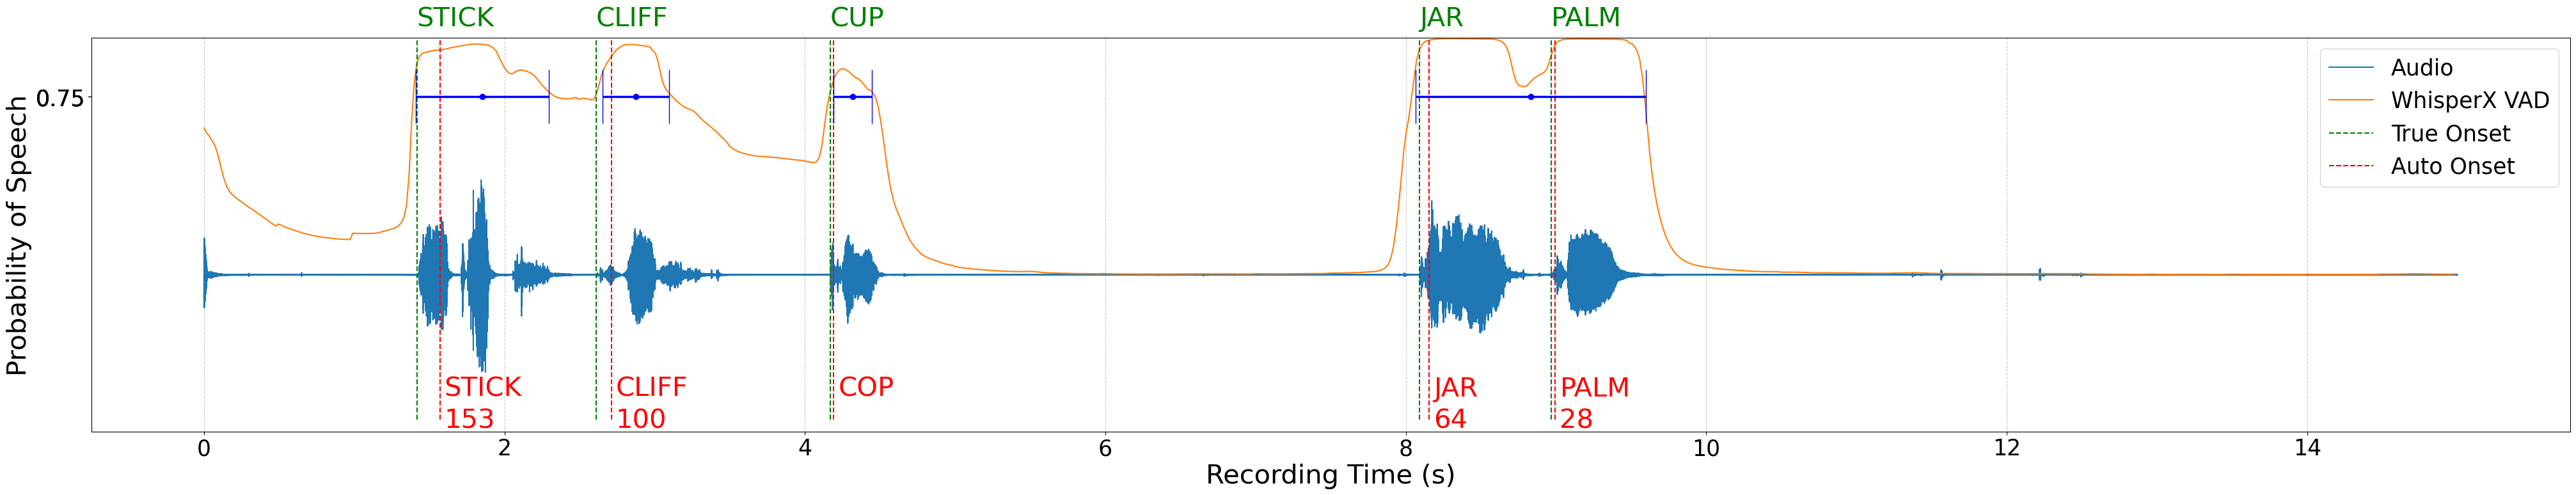

In [218]:
# TODO 
# check for last time point of VAD output

import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from whisperx.vad import Binarize


def plot_recall_recording(audio, vad_pred, ann, auto_ann, 
                          sr = 16000,  # sample rate in Hz
                          n_secs=15, plot_basename=None):
    # Penn-Total Recall defaults
    lowcut = 1000
    highcut = min(16000, sr / 2 - 1)
    order = 3
    b, a = butter(order, [lowcut, highcut], btype='band', fs=sr)
    audio_filt = filtfilt(b, a, audio)

    t = np.linspace(0, 30, len(audio))[:n_secs * sr]
    vad_out = vad_pred.data
    t_vad = np.linspace(0, 30, len(vad_out))[:int(n_secs / 30 * len(vad_out))]
    vad_plot = vad_out[:int(n_secs / 30 * len(vad_out))]
    plt.figure(figsize=(50, 8))
    audio_plot = audio_filt[:n_secs * sr] * 2.5 * vad_out.std() / audio_filt.max()
    plt.plot(t, audio_plot, label='Audio')
    yplot_min = np.max([audio_plot.min(), -0.7]) - 0.2
    plt.plot(t_vad, vad_plot, label='WhisperX VAD')
    for i, (_, row) in enumerate(ann.iterrows()):
        if row.onset / 1000 > n_secs: continue
        plt.text(x=row.onset / 1000, y=1.05, s=row.item_name, fontsize=30, color='g')
        if i == 0: plt.vlines(x=row.onset / 1000, ymin=yplot_min, ymax=1.0, linestyles='--', color='g', label='True Onset')
        else: plt.vlines(x=row.onset / 1000, ymin=yplot_min, ymax=1.0, linestyles='--', color='g')

    for i, (_, row) in enumerate(auto_ann.iterrows()):
        if row.onset / 1000 > n_secs: continue
        plt.text(x=row.onset / 1000 + 0.03, y=yplot_min+0.1, s=row.item_name, fontsize=30, color='r')
        true_ann = ann.query('item_name == @row.item_name')
        if true_ann.shape[0] > 1:
            # search for nearest match among repeats
            true_ann['diff'] = np.abs(true_ann.onset - row.onset)
            idx = np.argmin(true_ann['diff'])
            true_ann = true_ann.iloc[idx:idx+1]
            
        if true_ann.shape[0] == 1:
            err = row.onset - true_ann.onset.item()
            plt.text(x=row.onset / 1000 + 0.03, y=yplot_min -0.035, s=f'{int(err)}', fontsize=30, color='r')
        if i == 0: plt.vlines(x=row.onset / 1000, ymin=yplot_min, ymax=1.0, linestyles='--', color='r', label='Auto Onset')
        else: plt.vlines(x=row.onset / 1000, ymin=yplot_min, ymax=1.0, linestyles='--', color='r')

    plt.legend(fontsize=25)
    plt.xlabel('Recording Time (s)', fontsize=30)
    plt.xticks(fontsize=25)
    plt.ylabel('Probability of Speech', fontsize=30)
    _ = plt.yticks(fontsize=25)
    plt.ylim([yplot_min - 0.05, 1.0])
    
    vad_params = dict(onset=0.8, offset=0.78)
    # vad_params = dict(onset=0.5, offset=0.363)  # whisperX defaults
    binarize = Binarize(**vad_params)

    segments = binarize(vad_pred)

    segments_list = []
    for speech_turn in segments.get_timeline():
        segments_list.append([speech_turn.start, speech_turn.end])

    data = segments_list
    centers = [(a+b)/2 for a, b in data if b < n_secs]
    errors = [(b-a)/2 for a, b in data if b < n_secs]
    y_positions = [0.75] * len(centers)
    plt.errorbar(centers, y_positions, xerr=errors, fmt='o', linestyle='', color='b', ecolor='b', elinewidth=2.5, capsize=30)
    plt.yticks(y_positions)
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    
    if plot_basename:
        SaveFig(plot_basename)

plot_recall_recording(audio, vad_pred, ann, auto_ann)

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.1.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/torch/whisperx-vad-segmentation.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.0.0. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.0.1. Bad things might happen unless you revert torch to 1.x.


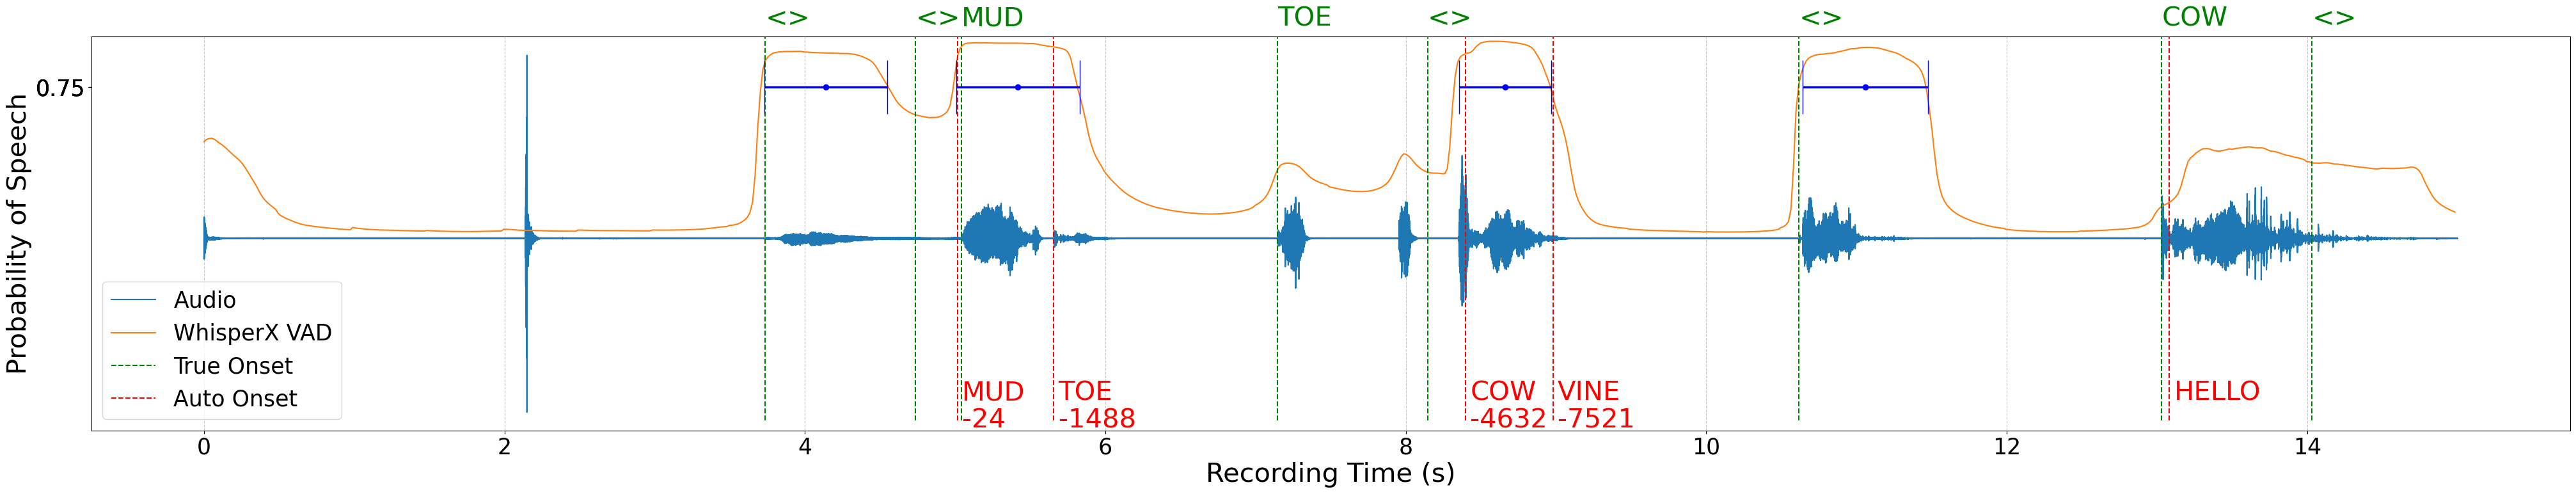

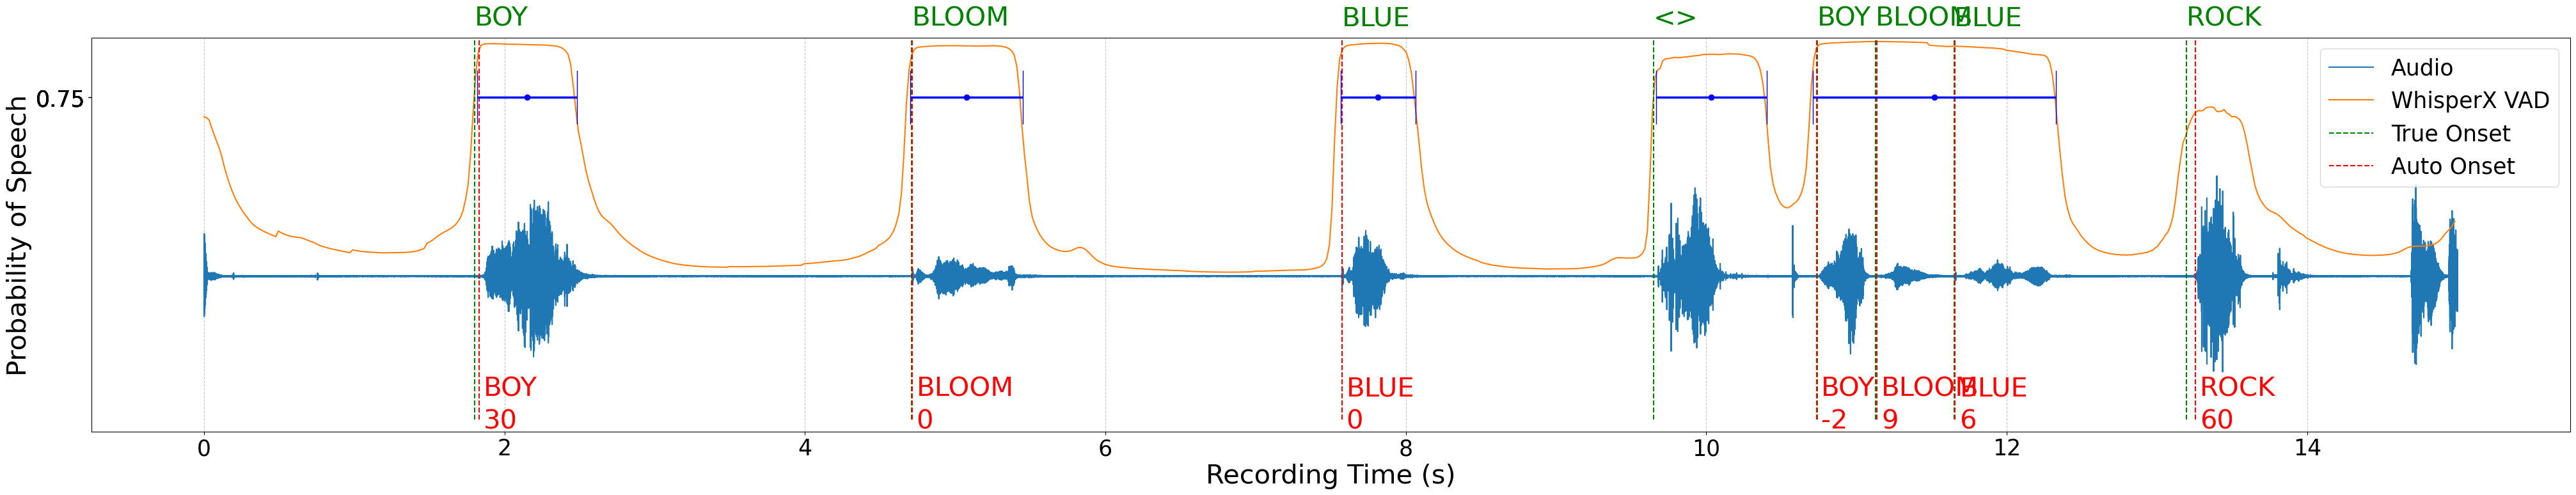

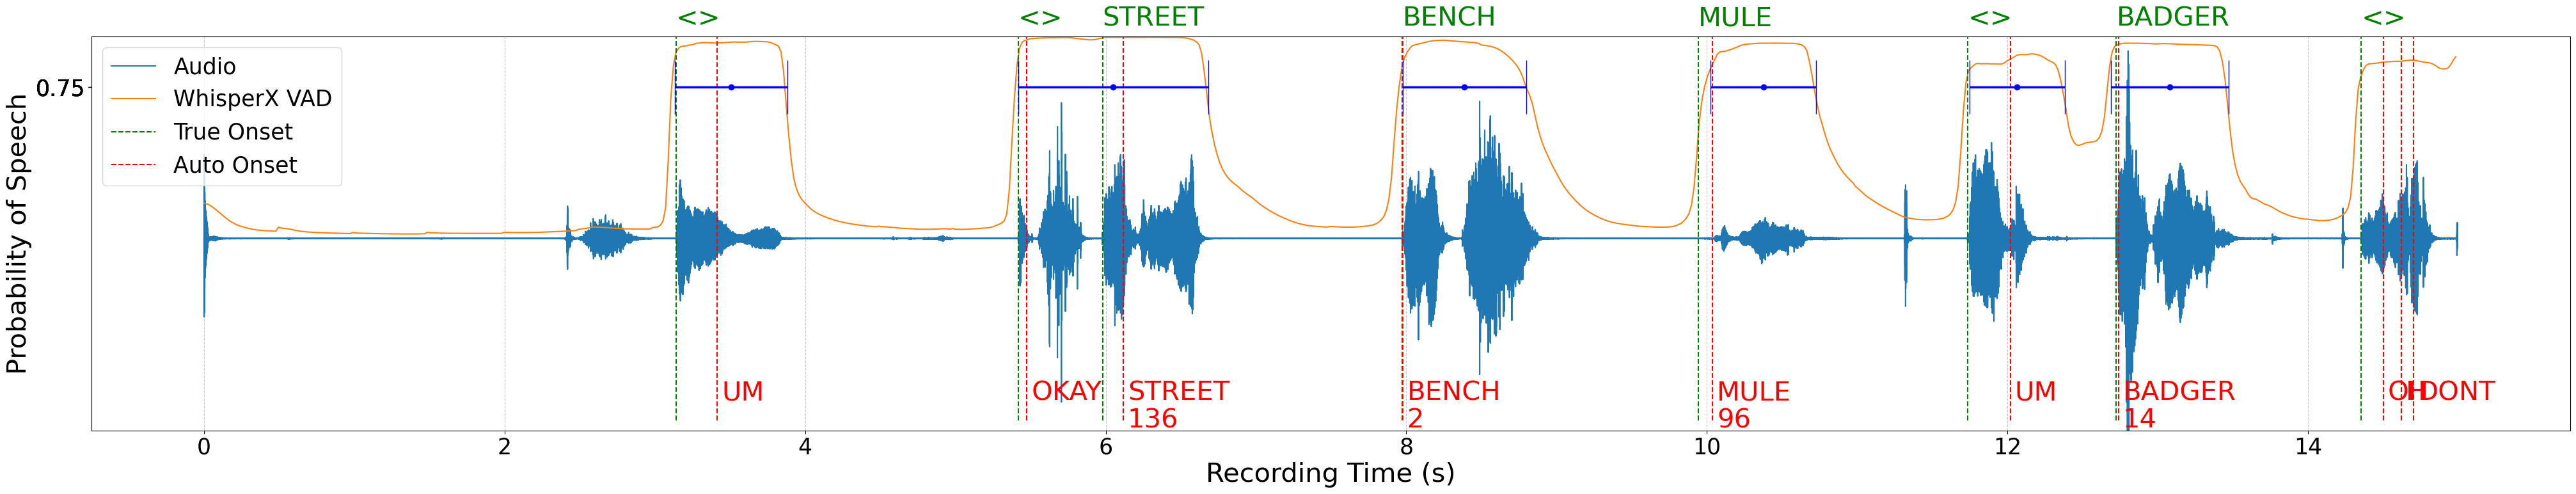

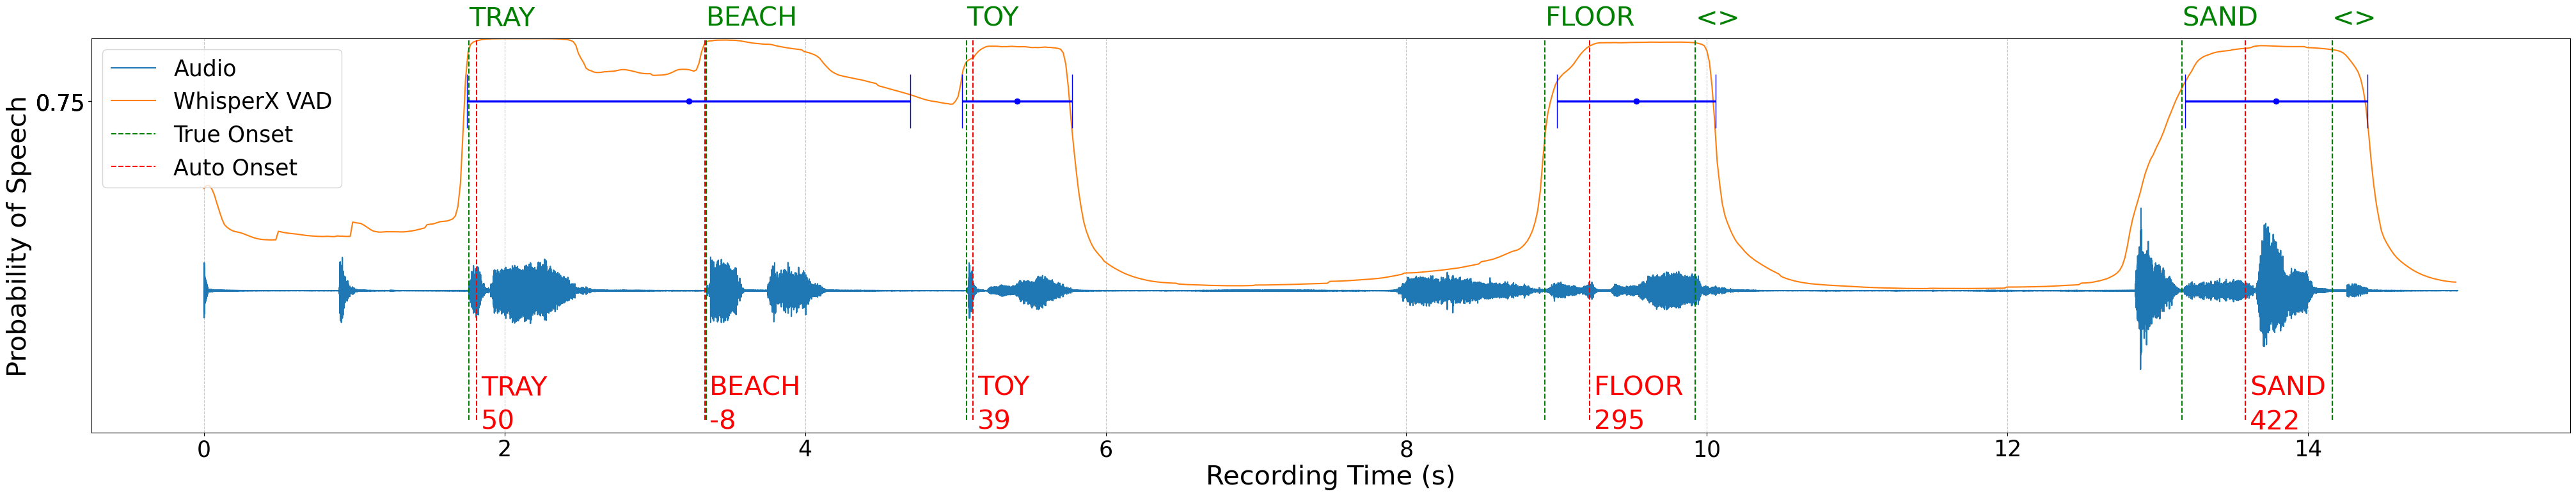

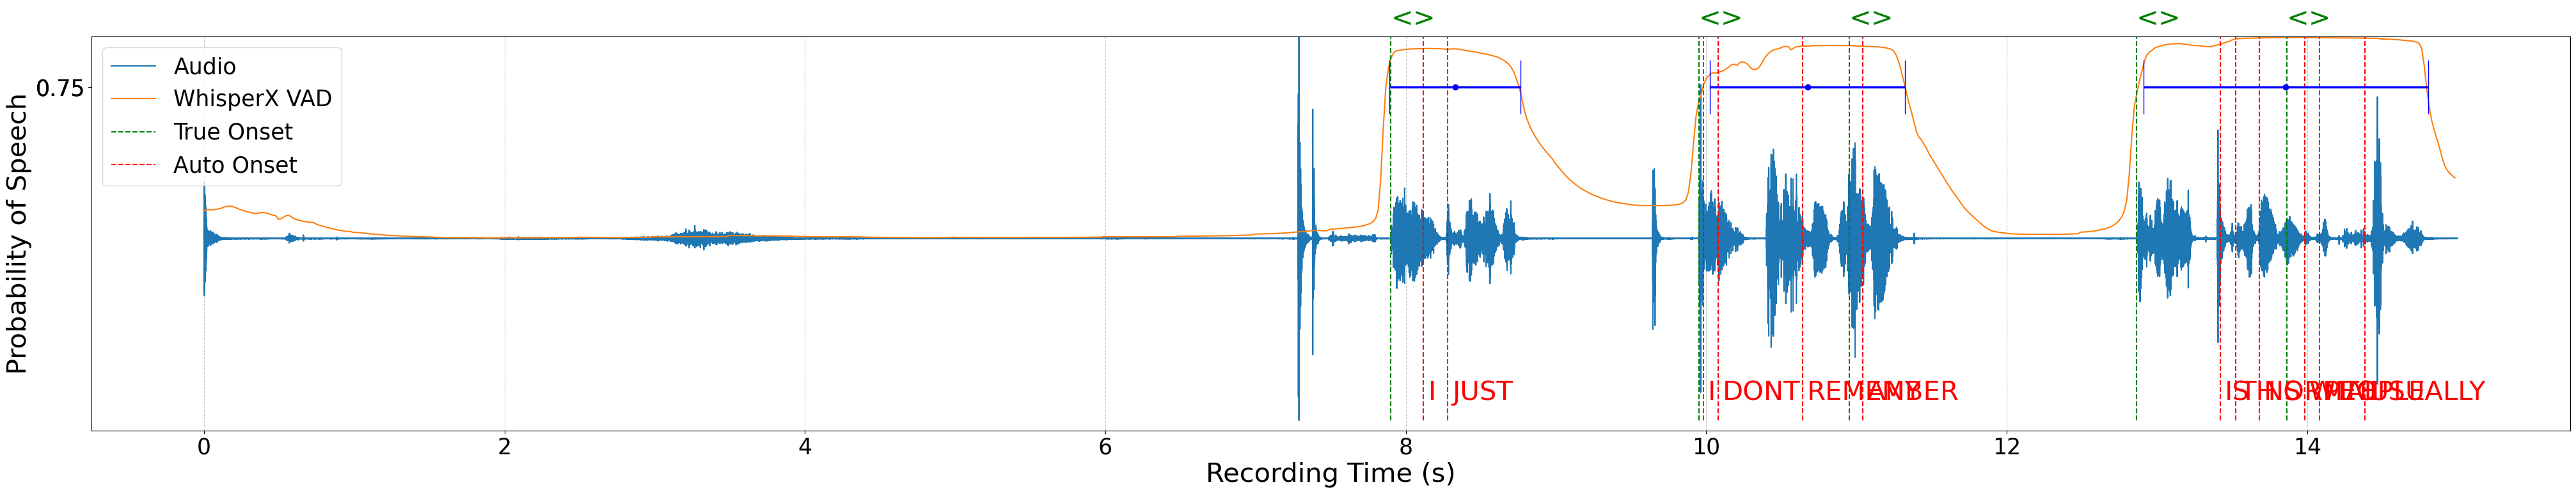

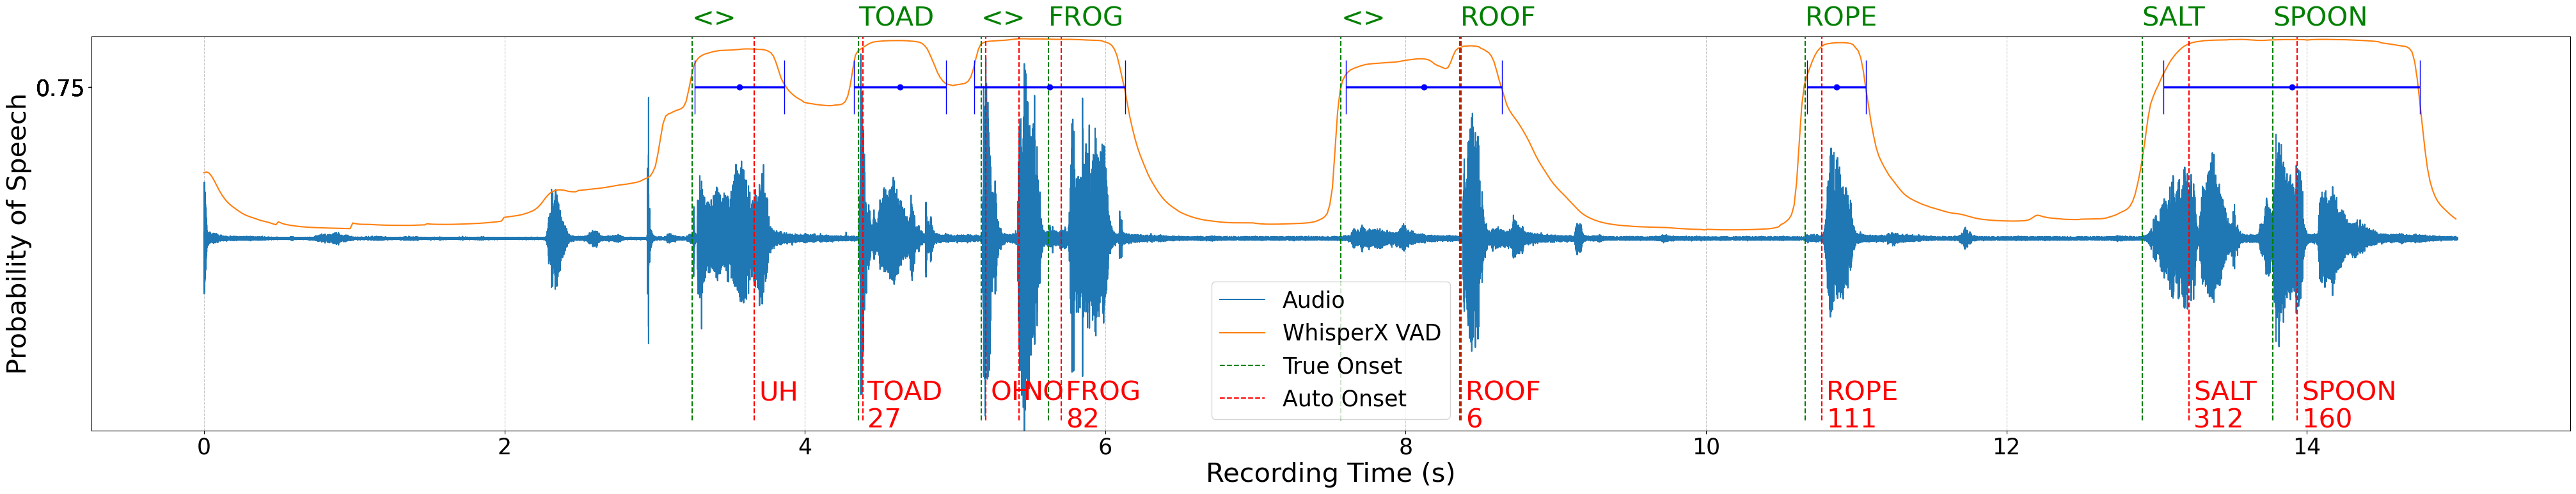

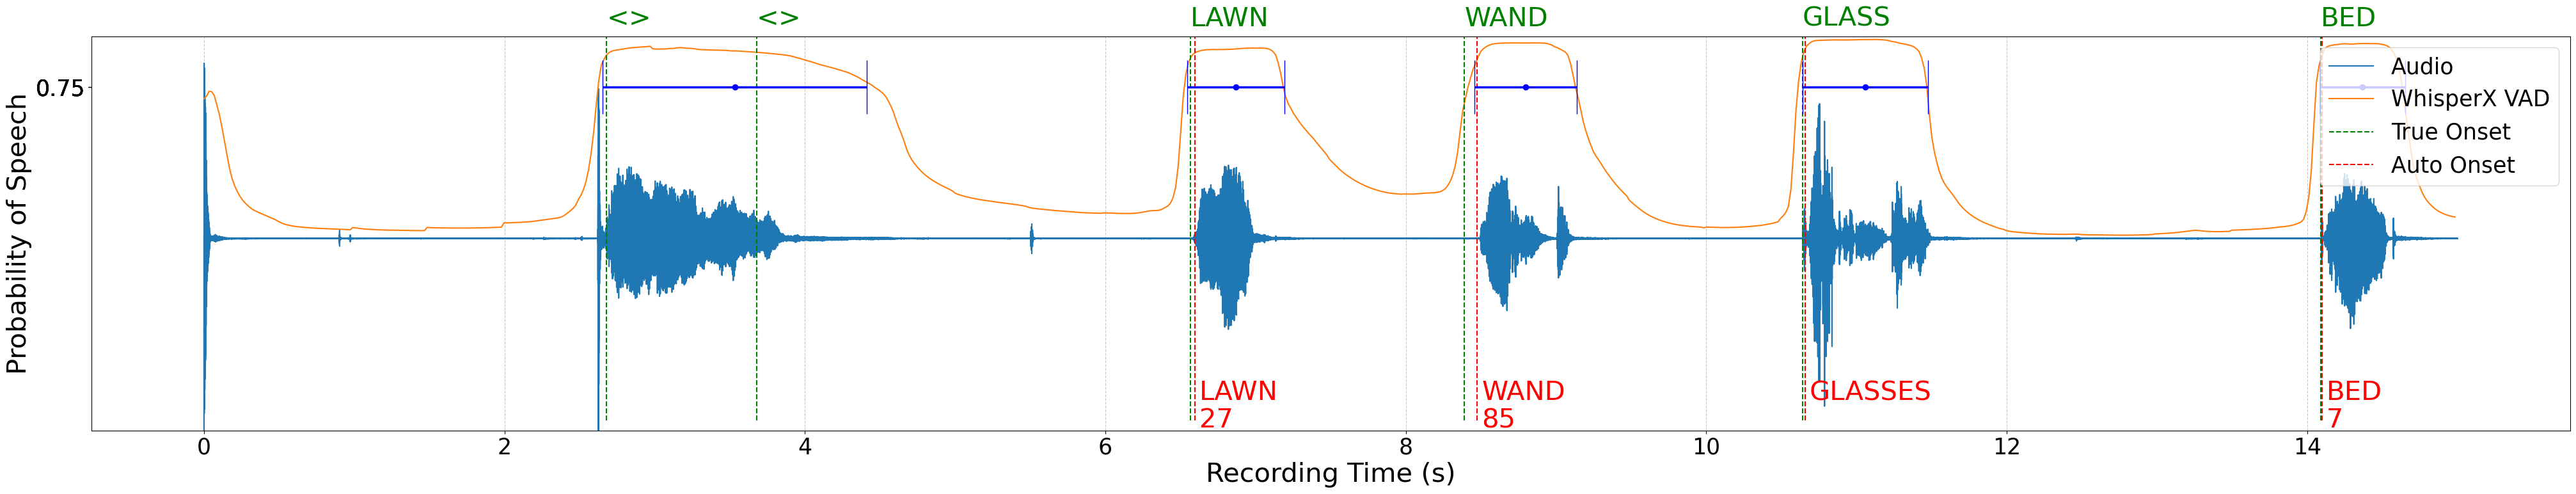

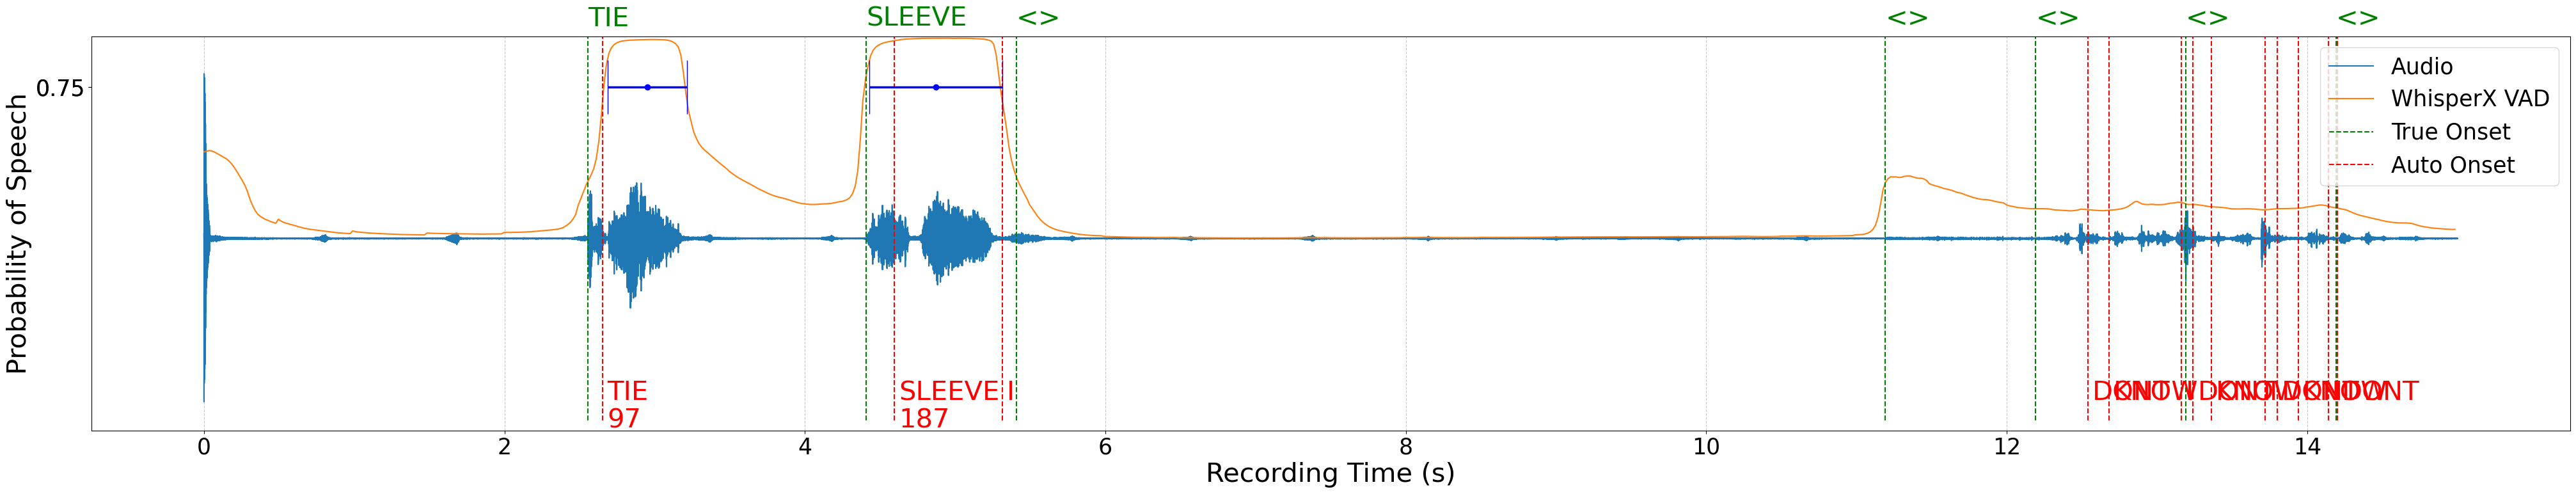

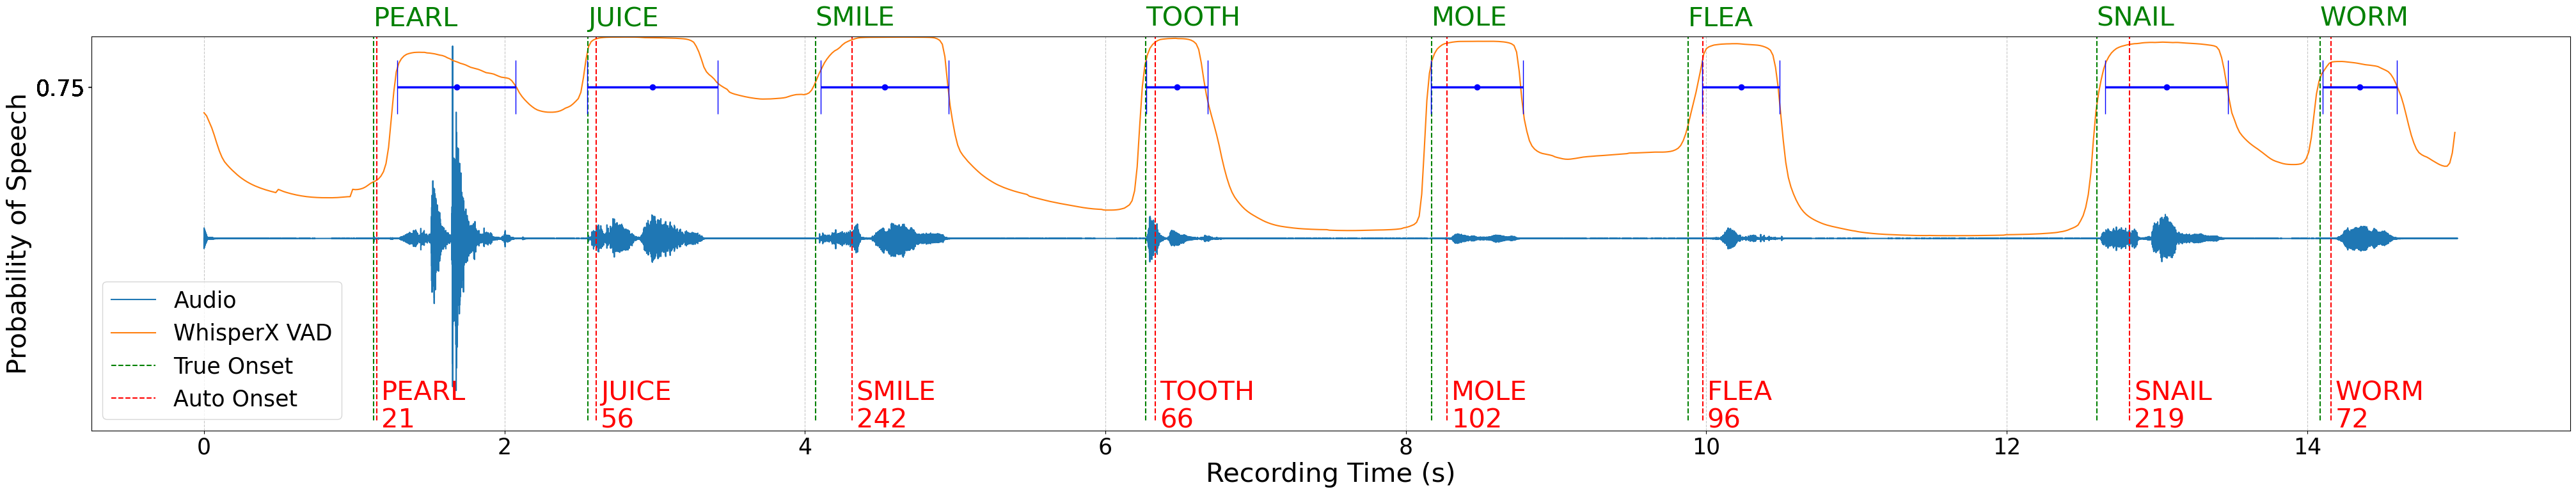

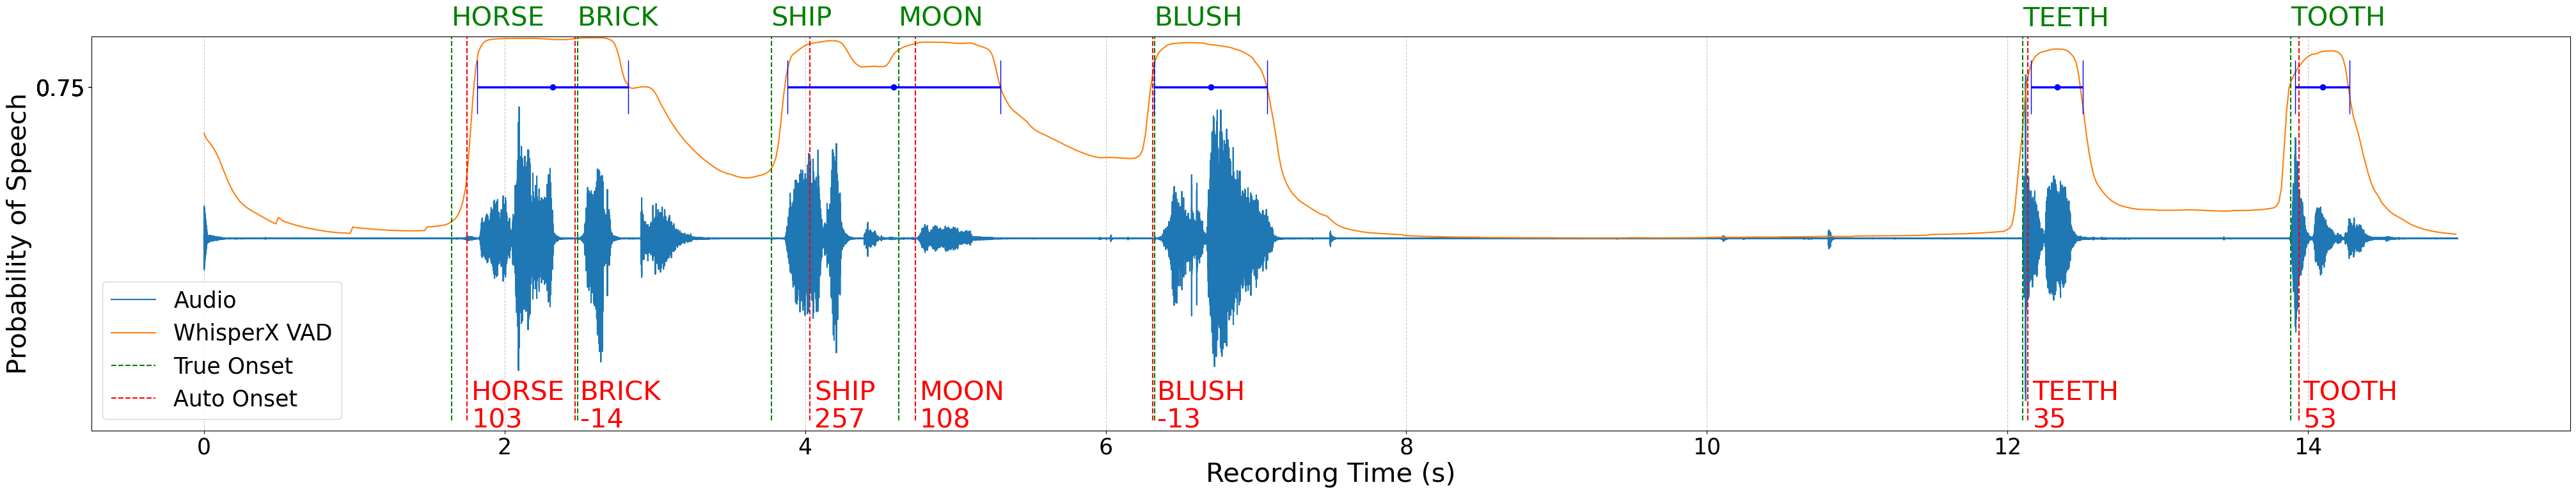

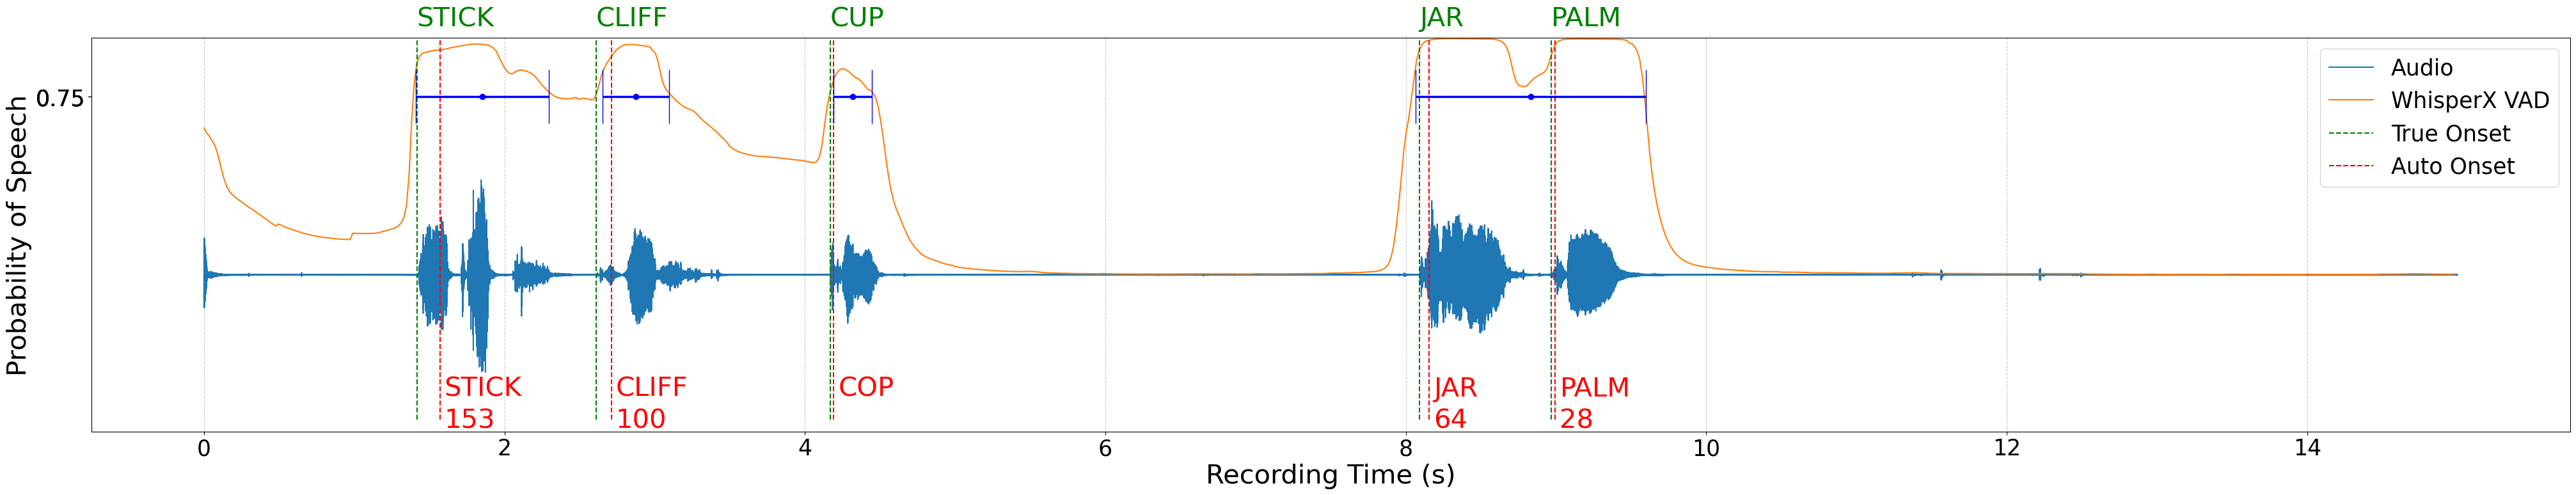

In [219]:
import numpy as np
import torch
import pickle
import pdb
from whisperx.vad import load_vad_model
from whisperx.asr import SAMPLE_RATE
import whisperx

use_gpu = False
device = "cuda:0" if use_gpu else "cpu"
vad = load_vad_model(device, vad_onset=0.500, vad_offset=0.363, use_auth_token=None, model_fp=None)


in_dir = 'test/whisperx_vad_fun/audio'
ann_dir = 'dependencies/annotation_gauntlet/session_0_QC'
# in_dir = 'dependencies/annotation_gauntlet/session_0'
# from gauntlet:
# hard initial phonemes: 11.wav
# mix of hard/soft initial phonemes: 10.wav

# with open('input_dirs.pkl', 'rb') as f:
#     input_dirs = pickle.load(f)
# in_dir = input_dirs['train'][0]

for list_num in range(1, 12): 
    file = in_dir + f'/{list_num}.npy'
    audio = np.load(file)
    # load .ann files, which demarcate end of header with blank line
    ann_file = os.path.join(ann_dir, f'{list_num}.ann')
    ann = load_ann(ann_file)[['item_name', 'onset', 'item_num']]
    
    auto_ann = pd.read_csv(os.path.join(ann_dir, 'whisperx_out', f'{list_num}.csv'))
    auto_ann = auto_ann.rename(columns={'Word': 'item_name', 'Onset': 'onset', 'Offset': 'offset', 'Probability': 'probability'})

    vad_pred = vad({"waveform": torch.from_numpy(audio).unsqueeze(0), "sample_rate": SAMPLE_RATE})
    plot_recall_recording(audio, vad_pred, ann, auto_ann, plot_basename=f'test/whisperx_vad_fun/plots/recall_period_list{list_num}')
    
plt.show()

In [165]:
auto_ann

,item_name,onset,offset,probability
0,MUD,5016,5637,0.888
1,TOE,5657,5717,0.001
2,COW,8399,8959,0.688
3,VINE,8979,9059,0.000
4,HELLO,13083,14664,0.545
5,HI,16566,16846,0.709
6,HEY,16946,17066,0.433
7,I,17146,17526,0.807
8,JUST,18107,18667,0.524
9,WANTED,19108,19488,0.496


In [166]:
ann

,item_name,onset,item_num
0,<>,3735.827664,-1
1,<>,4735.827664,-1
2,MUD,5040.816327,161
3,TOE,7145.646259,274
4,<>,8145.646259,-1
5,<>,10617.097506,-1
6,COW,13031.859410,65
7,<>,14031.859410,-1
8,VINE,16500.975057,286
9,<>,18060.952381,-1


In [201]:
segments_list

[[0.008532423208191127, 0.17918088737201365],
 [1.3907849829351537, 4.581911262798635],
 [7.994880546075086, 9.667235494880547],
 [17.261092150170647, 17.909556313993175],
 [28.677474402730375, 30.00853242320819]]